<a href="https://colab.research.google.com/github/Kushal-LTI/Blood-cancer-detection/blob/main/Custom_CNN_Model_2(updated).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import kagglehub
path = kagglehub.dataset_download('sumithsingh/blood-cell-images-for-cancer-detection')

print('Data source import complete.')

Using Colab cache for faster access to the 'blood-cell-images-for-cancer-detection' dataset.
Data source import complete.


In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import ParameterGrid
import warnings
from tensorflow.keras.layers import GlobalAveragePooling2D
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import random

warnings.filterwarnings('ignore')

(363, 360, 3)


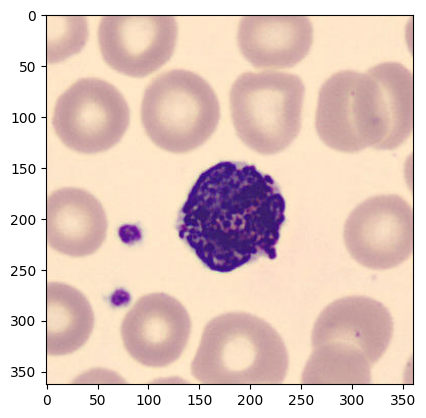

In [6]:
image_path = os.path.join(path, "basophil", "BA_100102.jpg")

try:
  img = mpimg.imread(image_path)
  plt.imshow(img)
  print(img.shape)
  plt.show()

except FileNotFoundError:
  print(f"Image file not found at: {image_path}")
  print("List of files in the basophil directory:")
  !ls basophil

In [7]:
data = []
directories = ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']

for directory in directories:
  directory_path = os.path.join(path, directory)
  for filename in os.listdir(directory_path):
    if filename.endswith(('.jpg')):
      image_path = os.path.join(directory_path, filename)
      data.append({'Image': image_path, 'Target': directory})

df = pd.DataFrame(data)
print(df.shape)

(5000, 2)


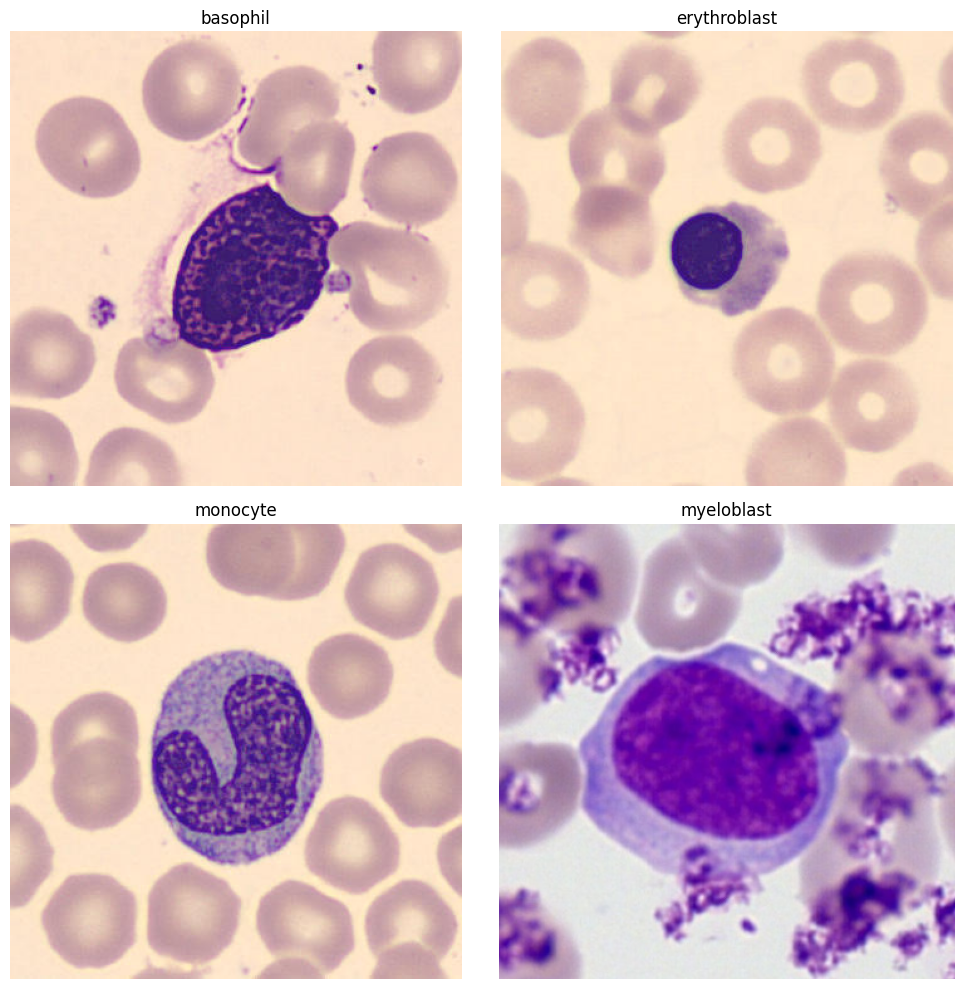

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.ravel()

unique_targets = df['Target'].unique()
num_unique_targets = len(unique_targets)

for i in range(min(4, num_unique_targets)):
    target = unique_targets[i]
    image_path = df[df['Target'] == target]['Image'].iloc[0]
    try:
        img = mpimg.imread(image_path)
        axes[i].imshow(img)
        axes[i].set_title(target)
        axes[i].axis('off')  # Hide axis ticks and labels
    except FileNotFoundError:
        print(f"Image file not found at: {image_path}")
        axes[i].set_title(f"Image not found for {target}")

# Adjust layout to prevent overlapping titles and labels
plt.tight_layout()
plt.show()

<center>

| Blood Cell Type | Main Purpose | Cancer Risk (%) |
|---|---|---|
| Basophil | Triggers allergic reactions, releases histamine & heparin | ~5% (in CML cases) |
| Erythroblast | Develops into red blood cells (RBCs), produces hemoglobin | ~10-15% (PV progressing to leukemia) |
| Monocyte | Becomes macrophages, engulfs pathogens, helps in immune defense | ~15-30% (CMML progressing to AML) |
| Myeloblast | Immature white blood cell precursor, develops into granulocytes | ~100% (AML originates from myeloblasts) |
| Segmented Neutrophil | First-line defense against bacterial infections, kills pathogens | ~10-40% (high-risk MDS progressing to AML) |

 Some blood cells can turn into cancer if they grow abnormally. Myeloblasts have the highest risk (100%) because they can directly cause leukemia. Monocytes (15-30%) and erythroblasts (10-15%) have a moderate risk, while basophils (~5%) and neutrophils (10-40%) can sometimes indicate cancer but are less likely to turn cancerous themselves. </center>

In [9]:
dfs = {}
# Iterate through unique targets
for target in df['Target'].unique():
  # Filter DataFrame for the current target
  df_target = df[df['Target'] == target]
  # Split into train, validation, and test sets
  train_df, temp_df = train_test_split(df_target, train_size=700, random_state=42, shuffle=True)
  val_df, test_df = train_test_split(temp_df, train_size=0.5, random_state=42, shuffle=True)

  # Store the DataFrames in the dictionary
  dfs[target] = {'train': train_df, 'val': val_df, 'test': test_df}

train_df = pd.concat([dfs[target]['train'] for target in dfs])
val_df = pd.concat([dfs[target]['val'] for target in dfs])
test_df = pd.concat([dfs[target]['test'] for target in dfs])

# Print the shapes of the resulting DataFrames
print("Train DataFrame shape:", train_df.shape)
print("Validation DataFrame shape:", val_df.shape)
print("Test DataFrame shape:", test_df.shape)

Train DataFrame shape: (3500, 2)
Validation DataFrame shape: (750, 2)
Test DataFrame shape: (750, 2)


In [10]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255
)


train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="Image",
    y_col="Target",
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale'
)

val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="Image",
    y_col="Target",
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale'
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="Image",
    y_col="Target",
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale'
)


Found 3500 validated image filenames belonging to 5 classes.
Found 750 validated image filenames belonging to 5 classes.
Found 750 validated image filenames belonging to 5 classes.


In [ ]:
data = []
directories = ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']

for directory in directories:
  directory_path = os.path.join(path, directory)
  for filename in os.listdir(directory_path):
    if filename.endswith(('.jpg')):
      image_path = os.path.join(directory_path, filename)
      data.append({'Image': image_path, 'Target': directory})

df = pd.DataFrame(data)
print(df.shape)

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.ravel()

unique_targets = df['Target'].unique()
num_unique_targets = len(unique_targets)

for i in range(min(4, num_unique_targets)):
    target = unique_targets[i]
    image_path = df[df['Target'] == target]['Image'].iloc[0]
    try:
        img = mpimg.imread(image_path)
        axes[i].imshow(img)
        axes[i].set_title(target)
        axes[i].axis('off')  # Hide axis ticks and labels
    except FileNotFoundError:
        print(f"Image file not found at: {image_path}")
        axes[i].set_title(f"Image not found for {target}")

# Adjust layout to prevent overlapping titles and labels
plt.tight_layout()
plt.show()

<center>

| Blood Cell Type | Main Purpose | Cancer Risk (%) |
|---|---|---|
| Basophil | Triggers allergic reactions, releases histamine & heparin | ~5% (in CML cases) |
| Erythroblast | Develops into red blood cells (RBCs), produces hemoglobin | ~10-15% (PV progressing to leukemia) |
| Monocyte | Becomes macrophages, engulfs pathogens, helps in immune defense | ~15-30% (CMML progressing to AML) |
| Myeloblast | Immature white blood cell precursor, develops into granulocytes | ~100% (AML originates from myeloblasts) |
| Segmented Neutrophil | First-line defense against bacterial infections, kills pathogens | ~10-40% (high-risk MDS progressing to AML) |

 Some blood cells can turn into cancer if they grow abnormally. Myeloblasts have the highest risk (100%) because they can directly cause leukemia. Monocytes (15-30%) and erythroblasts (10-15%) have a moderate risk, while basophils (~5%) and neutrophils (10-40%) can sometimes indicate cancer but are less likely to turn cancerous themselves. </center>

In [11]:
dfs = {}
# Iterate through unique targets
for target in df['Target'].unique():
  # Filter DataFrame for the current target
  df_target = df[df['Target'] == target]
  # Split into train, validation, and test sets
  train_df, temp_df = train_test_split(df_target, train_size=700, random_state=42, shuffle=True)
  val_df, test_df = train_test_split(temp_df, train_size=0.5, random_state=42, shuffle=True)

  # Store the DataFrames in the dictionary
  dfs[target] = {'train': train_df, 'val': val_df, 'test': test_df}

train_df = pd.concat([dfs[target]['train'] for target in dfs])
val_df = pd.concat([dfs[target]['val'] for target in dfs])
test_df = pd.concat([dfs[target]['test'] for target in dfs])

# Print the shapes of the resulting DataFrames
print("Train DataFrame shape:", train_df.shape)
print("Validation DataFrame shape:", val_df.shape)
print("Test DataFrame shape:", test_df.shape)

Train DataFrame shape: (3500, 2)
Validation DataFrame shape: (750, 2)
Test DataFrame shape: (750, 2)


In [12]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255
)


train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="Image",
    y_col="Target",
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale'
)

val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="Image",
    y_col="Target",
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale'
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="Image",
    y_col="Target",
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale'
)


Found 3500 validated image filenames belonging to 5 classes.
Found 750 validated image filenames belonging to 5 classes.
Found 750 validated image filenames belonging to 5 classes.


(128, 128, 1)


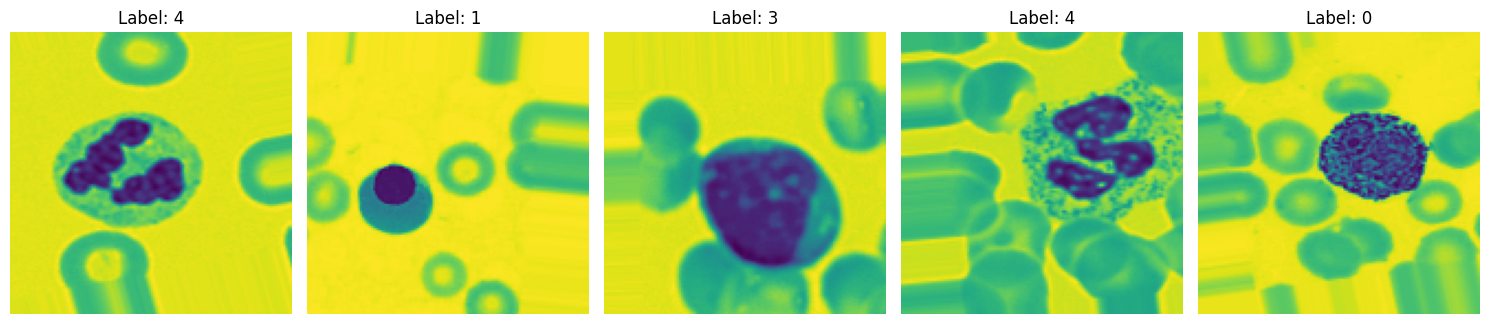

In [15]:
# Get a batch of images and labels from the training generator
images, labels = next(train_generator)

# Number of images to display
num_images = min(len(images), 5)

# Create a figure and subplots
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

# Iterate over the images and display them
for i in range(num_images):
    axes[i].imshow(images[i])
    axes[i].set_title(f"Label: {labels[i].argmax()}") # Display predicted class
    axes[i].axis('off')

print(images[0].shape)
plt.tight_layout()
plt.show()

In [16]:
def create_model(input_shape=(128, 128, 1)):
    """
    Create a CNN model with fixed architecture

    Args:
        input_shape: Shape of input images, default (128, 128, 1)

    Returns:
        Compiled Keras model
    """
    model = Sequential([
        # First convolutional block
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Third convolutional block
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Flatten and dense layers
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(5, activation='softmax')
    ])

    # Compile model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_model(model, train_generator, val_generator, epochs=30):
    """
    Train the model with early stopping and learning rate reduction

    Args:
        model: Compiled Keras model
        train_generator: Training data generator
        val_generator: Validation data generator
        epochs: Maximum number of epochs to train

    Returns:
        Training history and trained model
    """
    # Define callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-6
        )
    ]

    # Train the model
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=callbacks,
        verbose=1
    )

    return history, model

def plot_training_history(history):
    """
    Plot training history including accuracy and loss curves

    Args:
        history: Keras training history object
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Loss plot
    ax2.plot(history.history['loss'], label='Training')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    """
    Plot confusion matrix with class labels

    Args:
        y_true: True labels
        y_pred: Predicted labels
    """
    # Define class labels
    class_labels = ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

def print_classification_metrics(y_true, y_pred):
    """
    Print classification report with class labels

    Args:
        y_true: True labels
        y_pred: Predicted labels
    """
    class_labels = ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']

    report = classification_report(
        y_true,
        y_pred,
        target_names=class_labels,
        digits=4
    )
    print("\nClassification Report:")
    print(report)

def evaluate_model(model, test_generator):
    """
    Evaluate the model on test data

    Args:
        model: Trained Keras model
        test_generator: Test data generator

    Returns:
        Test loss, accuracy, and predicted classes
    """
    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)

    # Get predictions
    predictions = model.predict(test_generator)
    predicted_classes = predictions.argmax(axis=1)

    return test_loss, test_accuracy, predicted_classes

In [17]:
tf.random.set_seed(42)
np.random.seed(42)

# Define parameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 30

# Create and compile model
print("Creating model...")
model = create_model(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
model.summary()

# Train model
print("\nTraining model...")
history, trained_model = train_model(
    model,
    train_generator,
    val_generator,
    epochs=EPOCHS
)

# Evaluate model
print("\nEvaluating model...")
test_loss, test_accuracy, predictions = evaluate_model(trained_model, test_generator)
print(f'Test accuracy: {test_accuracy:.4f}')


Creating model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,518,661 (24.87 MB)

 Trainable params: 6,517,701 (24.86 MB)

 Non-trainable params: 960 (3.75 KB)


Training model...
Epoch 1/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.5741 - loss: 1.3961 - val_accuracy: 0.2000 - val_loss: 12.5138 - learning_rate: 0.0010
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.8609 - loss: 0.4142 - val_accuracy: 0.2000 - val_loss: 11.9181 - learning_rate: 0.0010
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.8957 - loss: 0.3139 - val_accuracy: 0.2000 - val_loss: 14.1309 - learning_rate: 0.0010
Epoch 4/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.9188 - loss: 0.2319 - val_accuracy: 0.2000 - val_loss: 11.9229 - learning_rate: 0.0010
Epoch 5/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.9181 - loss: 0.2297 - val_accuracy: 0.2373 - val_loss: 4.1687 - learning_rate: 0.0010
Epoch 6/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.9337 - loss: 0.1978 - val_accuracy: 0.7907 - val_loss: 0.5406 - learning_rate: 0.0010
Epoch 7/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accu

In [19]:
# Save the trained model
trained_model.save('blood_cell_classifier_2.h5')
print("Model saved to 'blood_cell_classifier_2.h5'")

Model saved to 'blood_cell_classifier_2.h5'



Plotting results...


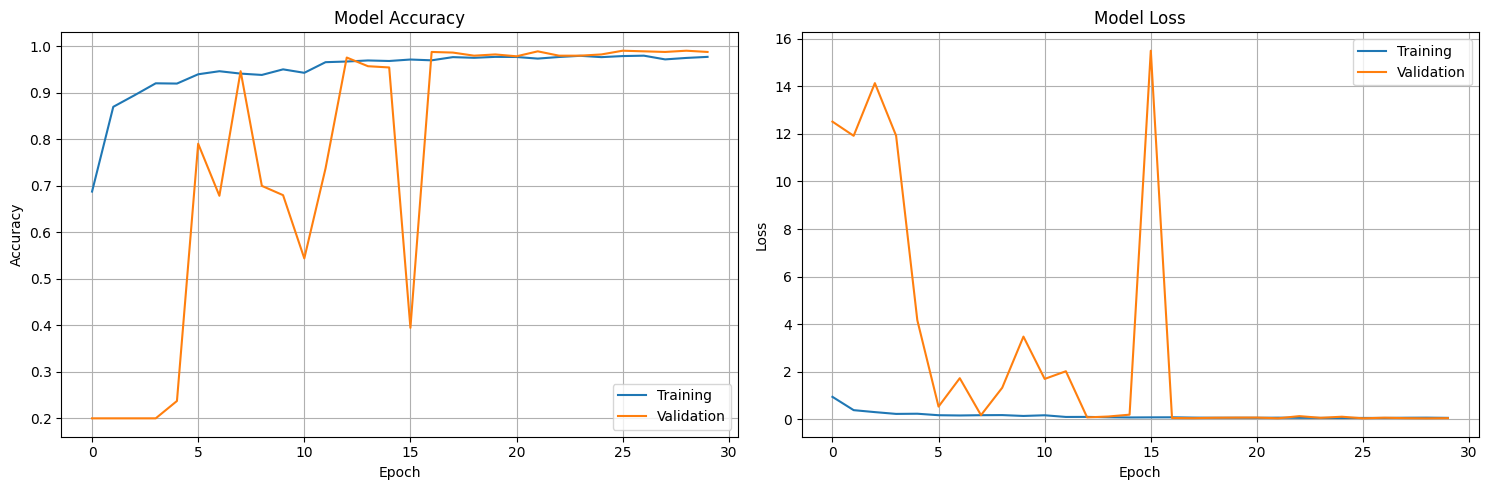

In [18]:
# Plot results
print("\nPlotting results...")
plot_training_history(history)

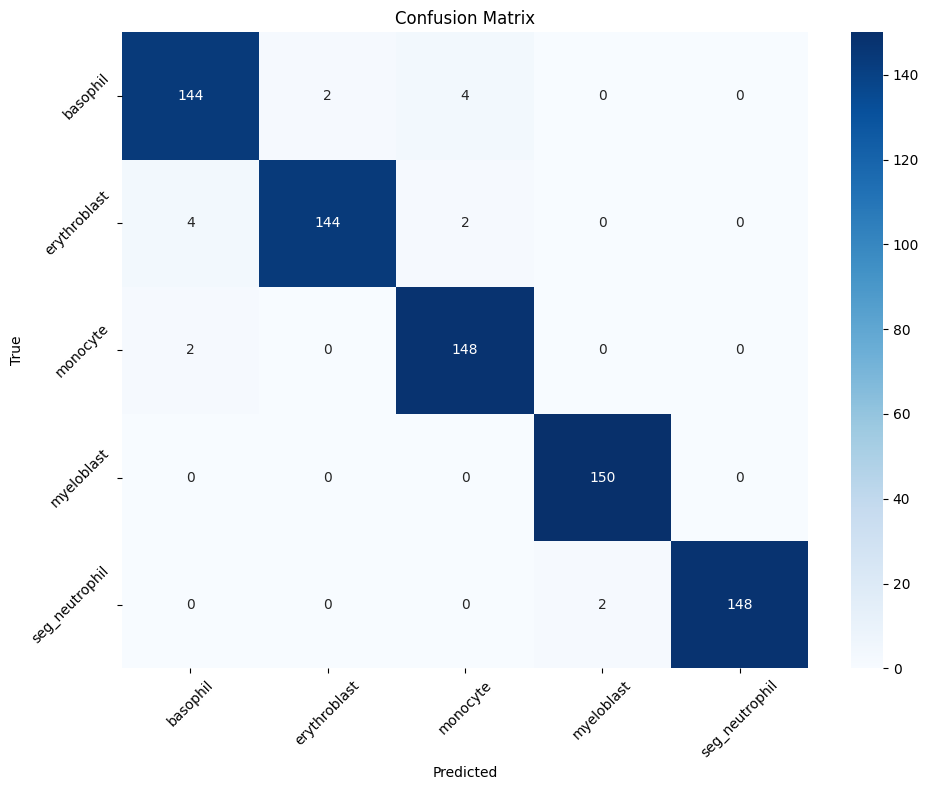


Classification Report:
                precision    recall  f1-score   support

      basophil     0.9600    0.9600    0.9600       150
  erythroblast     0.9863    0.9600    0.9730       150
      monocyte     0.9610    0.9867    0.9737       150
    myeloblast     0.9868    1.0000    0.9934       150
seg_neutrophil     1.0000    0.9867    0.9933       150

      accuracy                         0.9787       750
     macro avg     0.9788    0.9787    0.9787       750
  weighted avg     0.9788    0.9787    0.9787       750



In [20]:
# Get true labels from test generator
y_true = test_generator.classes

# Plot confusion matrix
plot_confusion_matrix(y_true, predictions)
print_classification_metrics(y_true, predictions)

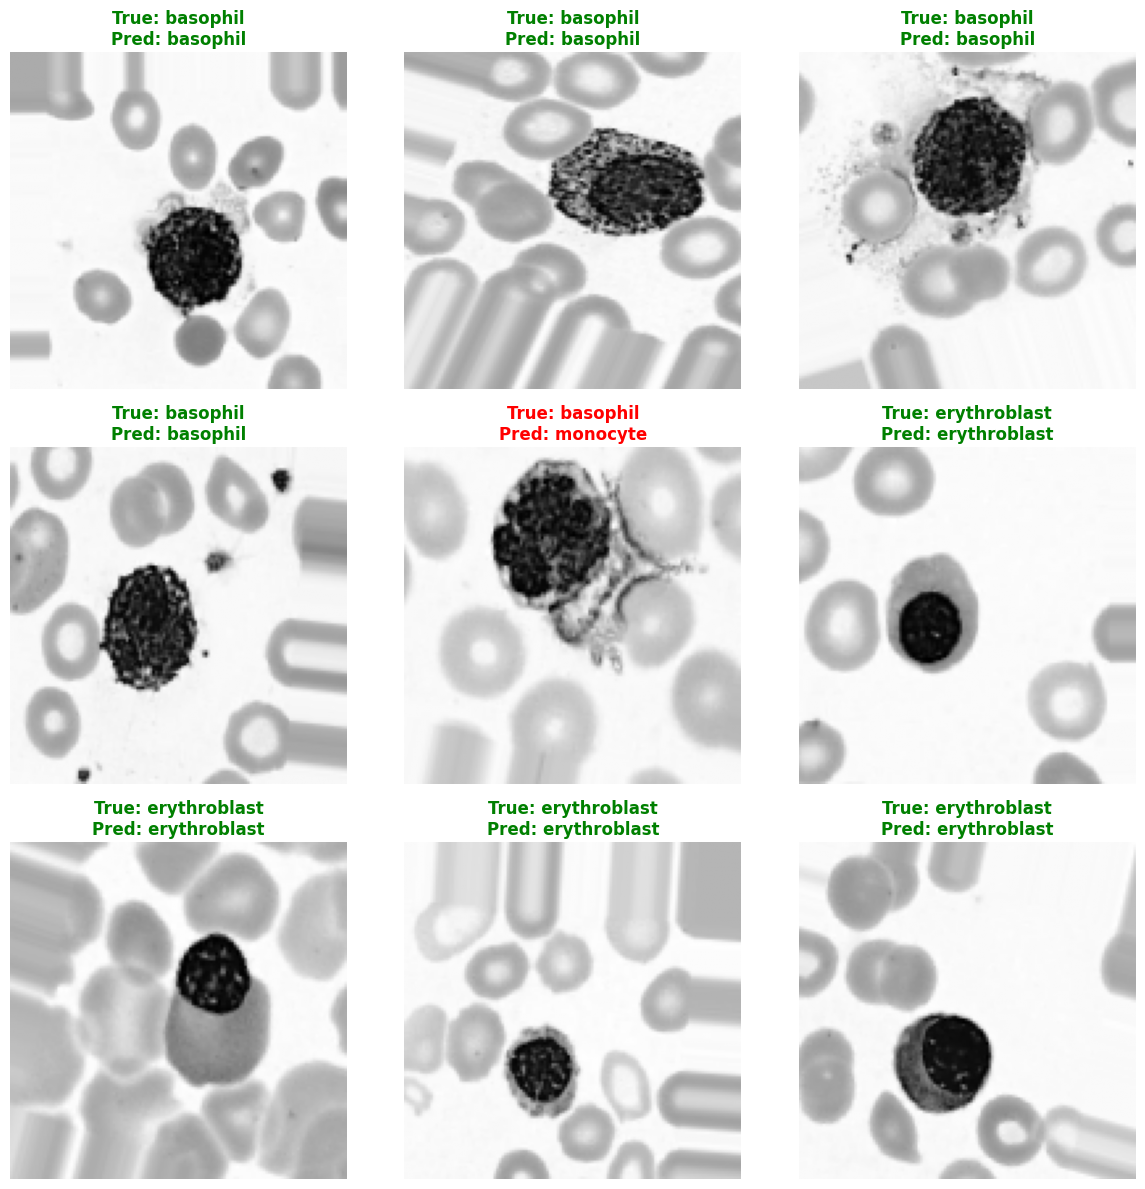

In [21]:

def show_random_predictions(model, test_generator):
    """
    Display 3x3 grid of random test images with predictions.
    """
    # Labels for our classes
    labels = ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']

    # Create 3x3 subplot
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))

    for i in range(3):
        for j in range(3):
            # Get a random batch and image from test generator
            batch_x, batch_y = next(test_generator)
            idx = random.randint(0, len(batch_x)-1)
            img = batch_x[idx]
            true_label = np.argmax(batch_y[idx])

            # Get prediction
            pred = model.predict(np.expand_dims(img, axis=0), verbose=0)
            pred_label = np.argmax(pred)

            # Determine text color (Green if correct, Red if wrong)
            color = 'green' if true_label == pred_label else 'red'

            # Plot image
            axes[i, j].imshow(np.squeeze(img), cmap='gray')
            axes[i, j].set_title(
                f'True: {labels[true_label]}\nPred: {labels[pred_label]}',
                color=color, fontsize=12, fontweight='bold'
            )
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Use it with your model:
show_random_predictions(trained_model, test_generator)